### Mount gdrive and correct path

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
%cd /gdrive/My Drive/AN2DL/homework1

/gdrive/My Drive/AN2DL/homework1


### Import libraries

In [ ]:
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
import cython as cy
import scipy as sy
import sklearn as sl
import skimage as si
# import pyyaml as py
import imutils as im
# import opencv as op
import tqdm as tq
import psutil as ps
import h5py as h5
import warnings
import logging

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)
tf.get_logger().setLevel('INFO')
tf.autograph.set_verbosity(0)

tf.get_logger().setLevel(logging.ERROR)
tf.get_logger().setLevel('ERROR')
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
warnings.filterwarnings("ignore")

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2.9.2


### Set seed, dataset folders and labels

In [ ]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

In [ ]:
# Dataset folders 
dataset_dir = 'dataset_folders'
training_dir = os.path.join(dataset_dir, 'train')
validation_dir = os.path.join(dataset_dir, 'val')

In [ ]:
labels = ['Species1',
          'Species2',
          'Species3',
          'Species4',
          'Species5',
          'Species6',
          'Species7',
          'Species8']

### Set hyperparameters and variables

In [ ]:
input_shape = (96, 96, 3)
input_size = (96, 96)
resized_shape = (224, 224, 3)
resized_size = (224,224)
epochs = 200
batch_size = 256
patience_epochs = 20
initial_learning_rate = 0.1 # variable learning rate (from more to less)

### Import dataset

In [ ]:
#Images are divided into folders, one for each class. 
# If the images are organized in such a way, we can exploit the 
# ImageDataGenerator to read them from disk.
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create an instance of ImageDataGenerator with Data Augmentation
datagen = ImageDataGenerator(rotation_range=90,
                             height_shift_range=0.1,
                             width_shift_range=0.1,
                             zoom_range=0.4,
                             brightness_range=[0.4,1.6],
                             horizontal_flip=True,
                             vertical_flip=True,
                             shear_range=0.2, 
                             fill_mode='reflect') 

validgen = ImageDataGenerator()

# Obtain a data generator with the 'ImageDataGenerator.flow_from_directory' method
train_gen = datagen.flow_from_directory(directory=training_dir,
                                        target_size=resized_size,
                                        interpolation="bicubic",
                                        color_mode='rgb',
                                        classes=None, # can be set to labels
                                        class_mode='categorical',
                                        batch_size=batch_size,
                                        shuffle=True,
                                        seed=seed)

valid_gen = validgen.flow_from_directory(directory=validation_dir,
                                        target_size=resized_size,
                                        interpolation="bicubic",
                                        color_mode='rgb',
                                        classes=None, # can be set to labels
                                        class_mode='categorical',
                                        batch_size=batch_size,
                                        shuffle=False)

Found 3007 images belonging to 8 classes.
Found 535 images belonging to 8 classes.


### Model paths

In [ ]:
# Create path
Model1 = "experiments/BEST_MODELS/EfficientNetV2B3/EfficientNetV2B3"
Model2 = "experiments/BEST_MODELS/Resnet152V2/Resnet152V2"
Model3 = "experiments/BEST_MODELS/DenseNet/DenseNet"

### Build ensemble model

In [ ]:
#Initiating the usage of individual models

keras_model1 = tf.keras.models.load_model(Model1, compile=False) 
keras_model1._name = 'Model1'
keras_model2 = tf.keras.models.load_model(Model2, compile=False) 
keras_model2._name = 'Model2'
keras_model3 = tf.keras.models.load_model(Model3, compile=False) 
keras_model3._name = 'Model3'
models = [keras_model1, keras_model2, keras_model3] #stacking individual models in a list
model_input = tf.keras.Input(shape=resized_shape) #takes a list of tensors as input, all of the same shape

model_outputs = [
    keras_model1(model_input),
    keras_model2(tf.keras.applications.resnet_v2.preprocess_input(model_input)),
    keras_model3(tf.keras.applications.densenet.preprocess_input(model_input))
]

ensemble_output = tf.keras.layers.Average()(model_outputs) #averaging outputs
ensemble_model = tf.keras.Model(inputs=model_input, outputs=ensemble_output)

In [ ]:
ensemble_model.summary() #prints a comprehensive summary of the Keras model

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 tf.math.truediv_1 (TFOpLambda)  (None, 224, 224, 3)  0          ['input_1[0][0]']                
                                                                                                  
 tf.math.truediv (TFOpLambda)   (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 tf.nn.bias_add (TFOpLambda)    (None, 224, 224, 3)  0           ['tf.math.truediv_1[0][0]']  

### Compile the model

In [ ]:
# exponential dynamic learning rate
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
initial_learning_rate,
decay_steps=100000, # 100 000 initially
decay_rate=0.96,
staircase=True)

# Compile the model

ensemble_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tf.keras.optimizers.SGD(learning_rate=lr_schedule), metrics='accuracy')

### Evaluate

In [ ]:
# Evaluate on test
ensemble_model_metrics = ensemble_model.evaluate(valid_gen, return_dict=True)

print()
print("Test metrics ensemble_model_metrics")
print(ensemble_model_metrics)

3/3 [==============================] - 131s 45s/step - loss: 0.2152 - accuracy: 0.9383

Test metrics ensemble_model_metrics
{'loss': 0.215152770280838, 'accuracy': 0.9383177757263184}


### Compute model predictions and import correct label values

In [ ]:
# Compute the prediction of a test. In our case we use the validation set generator since the amount of picture we have is low
predictions = ensemble_model.predict(valid_gen)
# Look at the shape of the predictions
print(f"Pred shape: {predictions.shape}")

3/3 [==============================] - 71s 15s/step
Pred shape: (535, 8)


In [ ]:
# Fill the y_true with the correct image label of the test set
true_test_lab = []
while len(true_test_lab) < predictions.shape[0]:
  try:
    batch = next(valid_gen)
    target = batch[1]
    for el in target:
      true_test_lab.append(el)
  except Exception:
    break
# Make it a numpy array
ttl_array = np.array(true_test_lab)
print("shape true labels: ", ttl_array.shape)

shape true labels:  (535, 8)


### Confusion Matrix

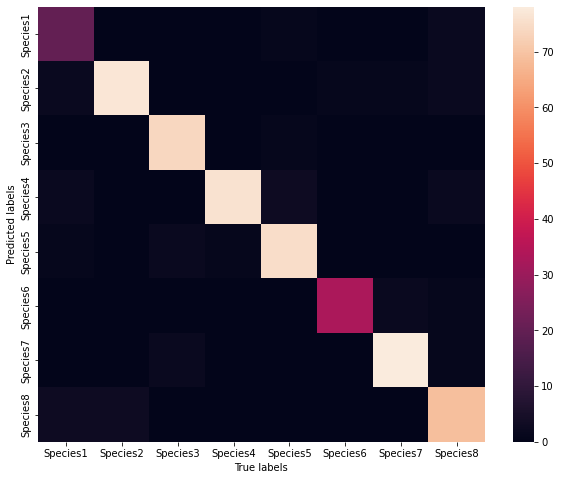

In [ ]:
#Create and plot the confusion matrix
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(np.argmax(ttl_array, axis=-1), np.argmax(predictions, axis=-1))

# Plot the confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(cm.T, xticklabels=list(labels), yticklabels=list(labels))
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

### Metrics

In [ ]:
#Here we compute accuracy, precision, recall and f1
accuracy = accuracy_score(np.argmax(ttl_array, axis=-1), np.argmax(predictions, axis=-1))
precision = precision_score(np.argmax(ttl_array, axis=-1), np.argmax(predictions, axis=-1), average='macro')
recall = recall_score(np.argmax(ttl_array, axis=-1), np.argmax(predictions, axis=-1), average='macro')
f1 = f1_score(np.argmax(ttl_array, axis=-1), np.argmax(predictions, axis=-1), average='macro')
print('Accuracy:',accuracy.round(4))
print('Precision:',precision.round(4))
print('Recall:',recall.round(4))
print('F1:',f1.round(4))


Accuracy: 0.9383
Precision: 0.9311
Recall: 0.9225
F1: 0.9254


### Save model

In [ ]:
ensemble_model.save(f"experiments/EnsembleModel3")